In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import pickle
import spliland
import importlib
import random
import fclParse
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

Welcome to JupyROOT 6.18/04


In [38]:
directory = './template_data_v2/set_2/'

In [39]:
tf.config.run_functions_eagerly(True)

## Intro

The purpose of this notebook is to make a second attempt at a neural network, following along with what was described in the paper "Deep Learning Based Pulse Shape Analysis for GERDA" by Philipp Holl in 2017. This algorithm consists of an autoencoder, decoder, and then classifier.

I am also following this guide: https://keras.io/examples/timeseries/timeseries_anomaly_detection/ for the implementation of the layers described in the paper into python

### Prep the data

In [40]:
n_points = 4500

with open(directory + 'x.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_train = []
    x_test = []
    for x in biggestX[:n_points]:
        x_train.append(x)
    for x in biggestX[n_points:n_points+500]:
        x_test.append(x)
    xFile.close()

with open(directory + 'y.data', 'rb') as yFile:
    biggestY = pickle.load(yFile)
    y_train = biggestY[:n_points]
    y_test = biggestY[n_points:n_points+500]
    yFile.close()
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [41]:
X_train = np.reshape(x_train, (n_points, 21816, 1))
Y_train = np.reshape(y_train, (n_points, 1))

In [42]:
X_train.shape

(4500, 21816, 1)

### Classifier

In [51]:
classifier_model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(21816,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(20, activation='relu')
])

In [52]:
classifier_model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [53]:
print(X_train.shape)
print(Y_train.shape)

(4500, 21816, 1)
(4500, 1)


In [54]:
classifier_history = classifier_model.fit(X_train,
                                          Y_train,
                                          epochs=50)

Epoch 1/50
141/141 [==============================] - 5s 32ms/step - loss: 1.4962 - accuracy: 0.3689
Epoch 2/50
141/141 [==============================] - 6s 40ms/step - loss: 1.0625 - accuracy: 0.5251
Epoch 3/50
141/141 [==============================] - 7s 47ms/step - loss: 0.9249 - accuracy: 0.5767
Epoch 4/50
141/141 [==============================] - 6s 42ms/step - loss: 0.8097 - accuracy: 0.6351
Epoch 5/50
141/141 [==============================] - 6s 39ms/step - loss: 0.6954 - accuracy: 0.6980
Epoch 6/50
141/141 [==============================] - 6s 40ms/step - loss: 0.6126 - accuracy: 0.7449
Epoch 7/50
141/141 [==============================] - 6s 39ms/step - loss: 0.5410 - accuracy: 0.7891
Epoch 8/50
141/141 [==============================] - 6s 40ms/step - loss: 0.4160 - accuracy: 0.8387
Epoch 9/50
141/141 [==============================] - 6s 40ms/step - loss: 0.4452 - accuracy: 0.8304
Epoch 10/50
141/141 [==============================] - 6s 40ms/step - loss: 0.3537 - accura

### Performance Stats

No handles with labels found to put in legend.
No handles with labels found to put in legend.


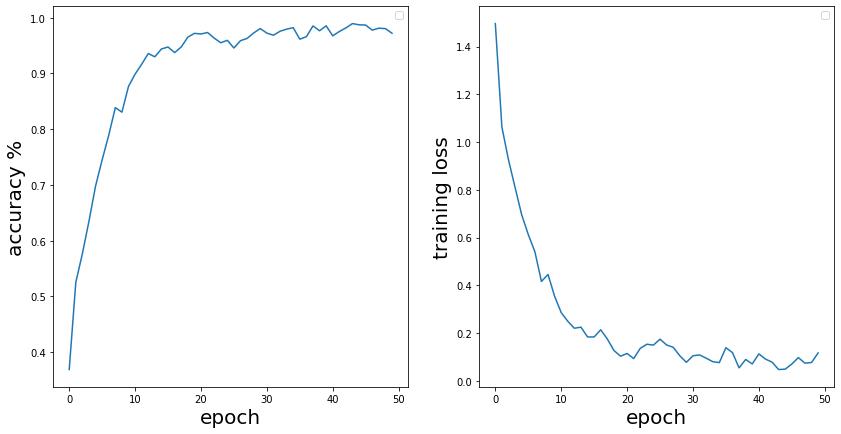

In [55]:
fig, ax = plt.subplots(1,2);
fig.set_size_inches(14,7);

ax[0].plot(classifier_history.history['accuracy'])

ax[0].set_xlabel("epoch", fontsize=20)
ax[0].set_ylabel("accuracy %", fontsize=20)
ax[0].legend()

ax[1].plot(classifier_history.history['loss'])

ax[1].set_xlabel("epoch", fontsize=20)
ax[1].set_ylabel("training loss", fontsize=20)
ax[1].legend()

In [56]:
Y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

matrix = confusion_matrix(y_test, y_pred, normalize='true', labels=[0,1,2,3,4,5,6])

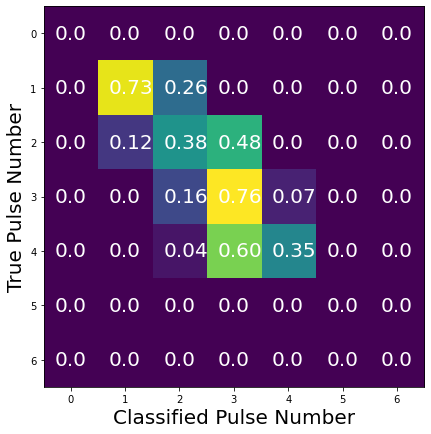

In [57]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)

labels = ['0', '1', '2', '3', '4', '5', '6']

grid = np.array(matrix)
im = ax.imshow(grid)

for k in range (0, len(grid)):
        for l in range (0, len(grid[0])):
            ax.text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color='white')
            
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);

ax.set_ylabel('True Pulse Number', fontsize=20);
ax.set_xlabel('Classified Pulse Number', fontsize=20);

#ax.set_title("with autoencoder", fontsize=20)


(array([ 92.,   0.,   0., 106.,   0.,   0., 244.,   0.,   0.,  58.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

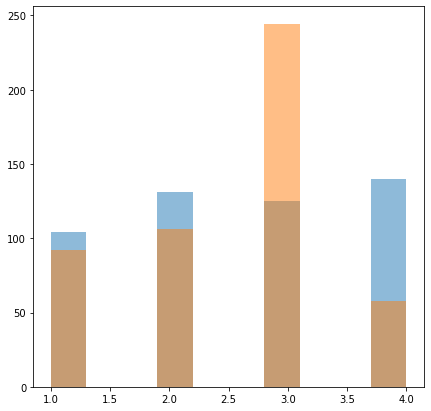

In [59]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 7)

ax.hist(y_test, alpha=0.5, label='True Pulse Number')
ax.hist(y_pred, alpha=0.5, label='Classified Pulse Number')
